In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse import linalg

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

## Import data

In [2]:
def plot(img):
    plt.figure(1)
    plt.imshow(img, cmap='Greys_r')
    
def comparePlot(original_image, img):
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(original_image, cmap='Greys_r')    
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(img, cmap='Greys_r') 

def comparePlotList(original_image, imgList, lambdas, m, n):
    fig = plt.figure(figsize=(16, 8))
    imgList = [original_image] + imgList
    lambdas = [-1] + lambdas
    for i in range(len(imgList)):
        ax1 = fig.add_subplot(1, len(imgList), i + 1)
        ax1.set_title("lambda = "+ str(lambdas[i]))
        ax1.imshow(imgList[i], cmap='Greys_r')

In [3]:
def rescale(img, targetMin, targetMax):
    result = np.copy(img)
    minV = float('inf')
    maxV = -float('inf')
    for _, x in np.ndenumerate(result):
        minV = min(minV, x)
        maxV = max(maxV, x)
    for i, x in np.ndenumerate(result):
        result[i] = targetMin + (x - minV)*(targetMax- targetMin)/(maxV - minV)
    return result

Original image : shape = (480, 480, 3), data type = float32.


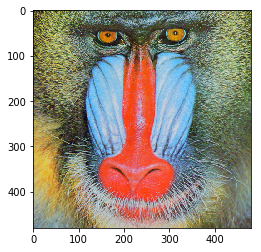

In [4]:
image_path = "mandrill.png"
original_image = mpimg.imread(image_path)
plot(original_image)
m, n = original_image.shape[0], original_image.shape[1]
print(
    "Original image : shape = {s}, data type = {dt}.".format(
        s=original_image.shape, dt=original_image.dtype))

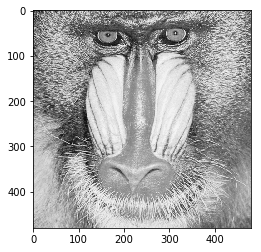

In [5]:
red  = original_image[:, :, 0]
green = original_image[:, :, 1]
blue = original_image[:, :, 2]
grayscale = (red + green + blue) / 3
plot(grayscale)

## Build WLS linear system

In [6]:
def w_frac(i, j, gi, gj, alpha_s, alpha_r):
    imj = i - j
    gimgj = gi - gj
    return 1 / ((np.dot(imj, imj) ** (alpha_s / 2) + 0.0001) * (np.dot(gimgj, gimgj) ** (alpha_r / 2) + 0.0001))

def w_exp(i, j, gi, gj, sigma_s, sigma_r):
    imj = i - j
    gimgj = gi - gj
    return np.e**(- np.dot(imj, imj) / (2 * sigma_s**2)) * np.e(- np.dot(gimgj, gimgj) / (2 * sigma_r**2))

In [7]:
def buildA(img, lambda_, r, par1, par2, useFracWeights=True):

    m , n = img.shape[0], img.shape[1] 
    size = m * n

    rowInd = []
    colInd = []
    data = []


    for i in range(m):
        mink = max(i - r, 0)
        for j in range(n):
            minl = max(j - r, 0)
            I = i * n + j
            tot = 0
            for k in range(mink, min(i + r + 1, m)):
                for l in range(minl, min(j + r + 1, n)):
                    J = k * n + l
                    if I != J:
                        if (useFracWeights):
                            val = lambda_ * w_frac(np.array([i, j]), np.array([k, l]), 
                                           original_image[i, j], original_image[k, l], par1, par2)
                        else:
                            val = lambda_ * w_exp(np.array([i, j]), np.array([k, l]), 
                                           original_image[i, j], original_image[k, l], par1, par2)
                        tot += val
                        rowInd.append(I)
                        colInd.append(J)
                        data.append(-val)
            rowInd.append(I)
            colInd.append(I)
            data.append(tot + 1)
        if i % 100 == 0 : print(i)
   
    return sp.coo_matrix((data, (rowInd, colInd)), shape=(size, size))

In [33]:
lambdas = [0.1, 0.4]
Us = []
r = 1
alphas = [1.2, 1.4]
for lambda_, alpha in zip(lambdas, alphas):
    A = buildA(grayscale, lambda_, r, alpha, alpha)
    U = sp.linalg.spsolve(A, grayscale.flatten())
    Us.append(U.reshape((m, n)))

0
100
200
300
400


C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


0
100
200
300
400


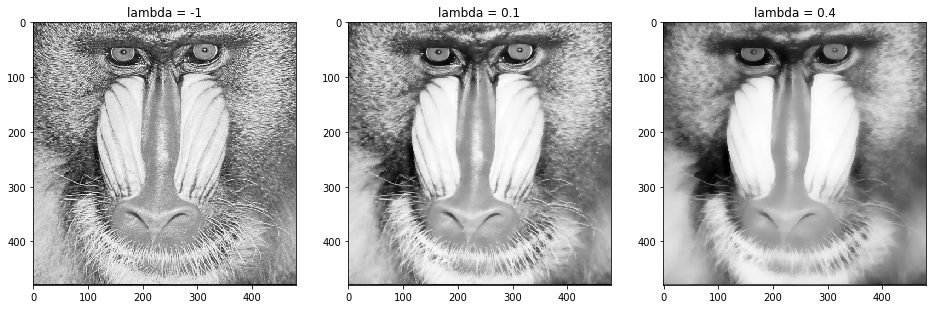

In [34]:
comparePlotList(grayscale, Us, lambdas, m, n)

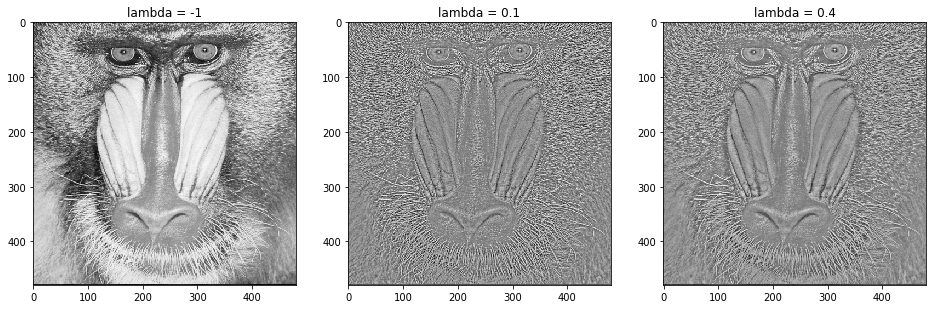

In [35]:
details = []
for U in Us:
    details.append(grayscale - U)
comparePlotList(grayscale, details, lambdas, m, n)

In [36]:
def sigmoid(a,x):
    return 1.0 / (1.0 + np.exp(-a * x))

In [37]:
def multiScaleCorrection(base, details, baseExposure, baseBoost, detailBoosts):
    mu = np.mean(base)
    result = np.full(base.shape, mu)
    result += sigmoid(baseBoost, baseExposure * base - mu)
    for D, d in zip(details, detailBoosts):
        result += sigmoid(d, D)
    return result

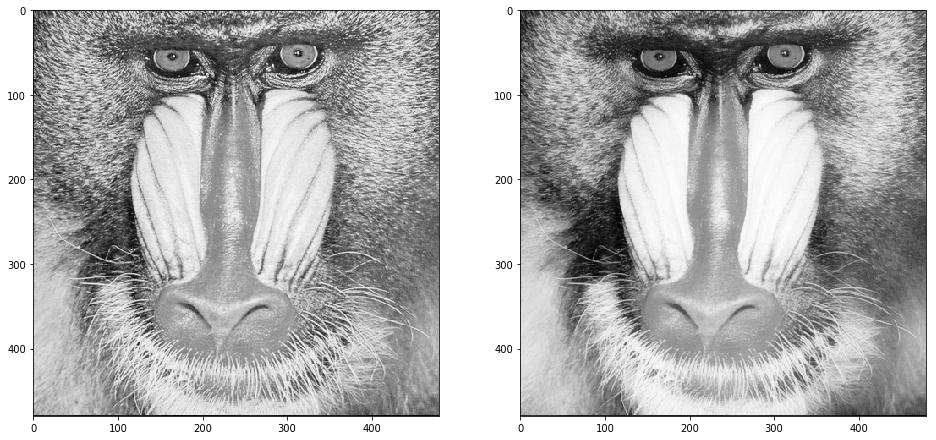

In [51]:
enhanced = multiScaleCorrection(Us[1], details, 1.0, 5.0, [1.0, 1.0])
comparePlot(grayscale, enhanced)

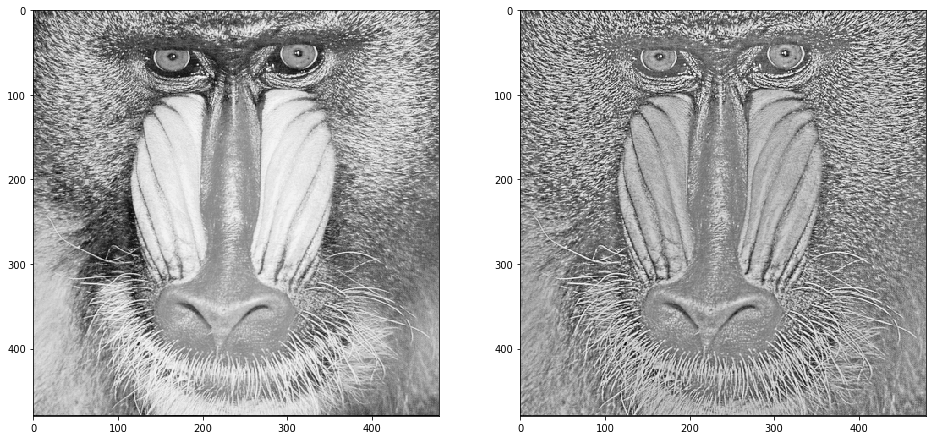

In [49]:
enhanced = multiScaleCorrection(Us[1], details, 1.0, 1.0, [1.0, 5.0])
comparePlot(grayscale, enhanced)

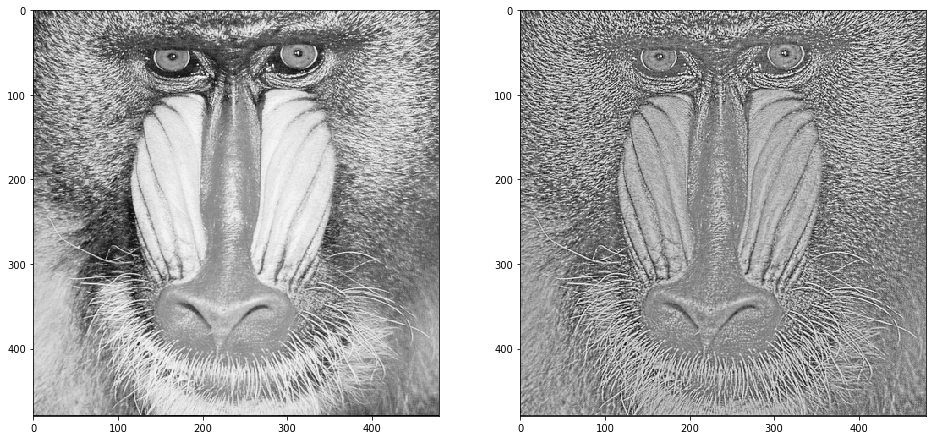

In [46]:
enhanced = multiScaleCorrection(Us[1], details, 1.0, 1.0, [5.0, 1.0])
comparePlot(grayscale, enhanced)

In [60]:
lambdas = [5, 40, 320]
UsRed, UsGreen, UsBlue = [], [], []
r = 1
alpha_r = alpha_s = 1.2
for lambda_ in lambdas:
    A = buildA(red, lambda_, r, alpha_s, alpha_r)
    U = sp.linalg.spsolve(A, red.flatten())
    UsRed.append(U.reshape((m, n)))
    A = buildA(green, lambda_, r, alpha_s, alpha_r)
    U = sp.linalg.spsolve(A, green.flatten())
    UsGreen.append(U.reshape((m, n)))
    A = buildA(blue, lambda_, r, alpha_s, alpha_r)
    U = sp.linalg.spsolve(A, blue.flatten())
    UsBlue.append(U.reshape((m, n)))

0
100
200
300
400


C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


0
100
200
300
400
0
100
200
300
400
0
100
200
300
400
0
100
200
300
400
0
100
200
300
400
0
100
200
300
400
0
100
200
300
400
0
100
200
300
400


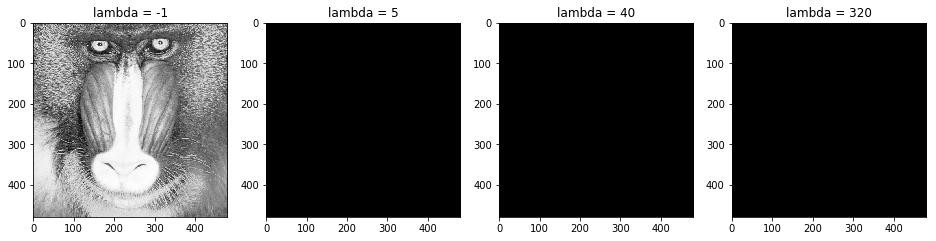

In [13]:
comparePlotList(red, UsRed, lambdas, m, n)

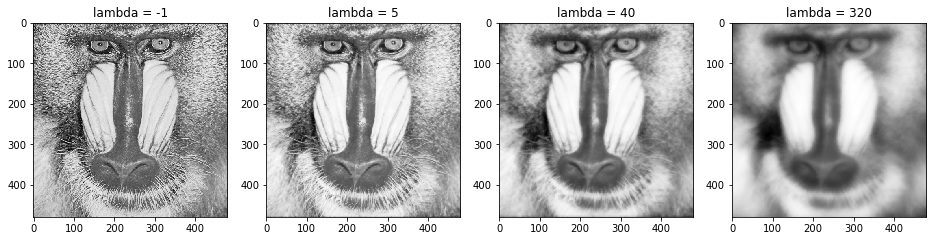

In [141]:
comparePlotList(green, UsGreen, lambdas, m, n)

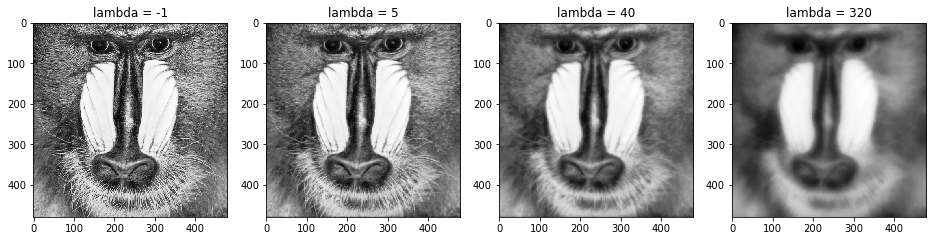

In [142]:
comparePlotList(blue, UsBlue, lambdas, m, n)

In [126]:
Us = []
for i in range(len(lambdas)):
    smoothed_img = np.empty_like(original_image)
    smoothed_img[:, :, 0] = UsRed[i]
    smoothed_img[:, :, 1] = UsGreen[i]
    smoothed_img[:, :, 2] = UsBlue[i]
    Us.append(smoothed_img)

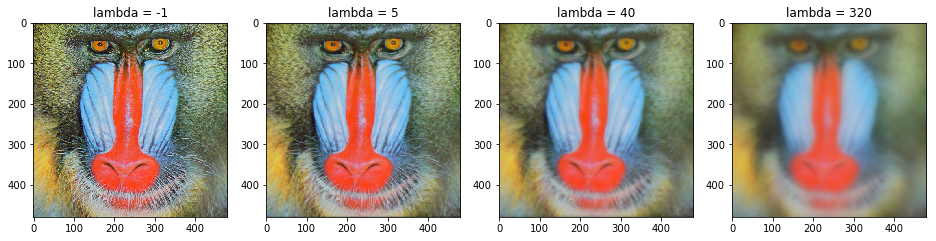

In [143]:
comparePlotList(original_image, Us, lambdas, m, n)

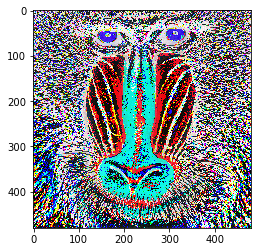

In [185]:
smoothed = Us[2]
details = original_image - smoothed
plot(details)

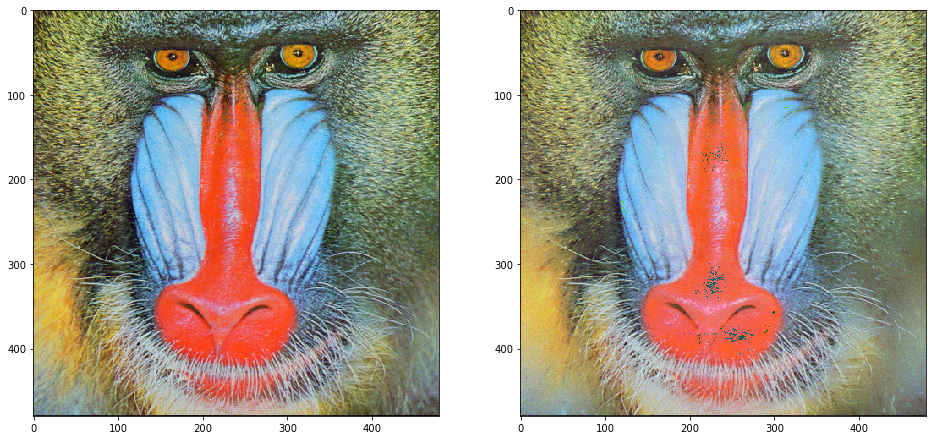

In [187]:
enhanced = original_image + (.1 * details).astype("uint8")
comparePlot(original_image, enhanced)

In [183]:
(.1 * details).astype("uint8")

array([[[ 5,  5,  2],
        [22, 22, 23],
        [23, 21, 22],
        ..., 
        [ 0,  0, 24],
        [ 2,  4,  2],
        [ 5,  6,  4]],

       [[ 2,  3,  1],
        [ 2,  0, 24],
        [20, 20, 23],
        ..., 
        [ 0,  1,  2],
        [ 1,  3,  4],
        [ 0,  1,  0]],

       [[25, 24, 24],
        [ 3,  3,  0],
        [21, 20, 24],
        ..., 
        [25, 22,  0],
        [23, 22, 25],
        [23, 21, 23]],

       ..., 
       [[ 0,  1,  2],
        [ 1,  2,  1],
        [ 1,  2,  1],
        ..., 
        [ 2,  0, 24],
        [ 1,  0, 25],
        [25,  0, 24]],

       [[ 1,  4,  3],
        [ 1,  2,  2],
        [ 1,  1, 25],
        ..., 
        [25,  0, 25],
        [ 1, 25,  0],
        [ 0, 24, 25]],

       [[16, 14, 14],
        [16, 14, 13],
        [16, 14, 17],
        ..., 
        [18, 19, 19],
        [18, 18, 18],
        [18, 18, 18]]], dtype=uint8)